Step 4: Basic Forecasting Model
Use the lastupdated feature as the time series index

Select a city or aggregate data for forecasting

Try models like:

Simple Moving Average

ARIMA

Facebook Prophet (if allowed)

Evaluate using metrics like MAE, RMSE

MODEL1 : ARIMA

Why ARIMA?

1. ARIMA is a classic, well-known statistical model for time series forecasting.
2. It can capture trends, seasonality (with seasonal ARIMA), and autocorrelation in the data.
3. Works well on univariate time series (like temperature over time).

How it uses last_updated?

last_updated is the time index. We sort and structure the data with respect to these timestamps so the ARIMA model forecasts the next values based on past observed values in the time series.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("cleaned_weather_data.csv")  # Adjust filename if different

# Convert 'last_updated' to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])


Prepare Time Series Data

In [6]:
# Set 'last_updated' as the index for time series
df_time = df.copy()
df_time = df_time[['last_updated', 'temperature_celsius']]
df_time = df_time.sort_values('last_updated')
df_time.set_index('last_updated', inplace=True)

# Ensure the index is in datetime format
df_time.index = pd.to_datetime(df_time.index)

# Optional: Resample data daily if not already daily
df_daily = df_time.resample('D').mean().interpolate()  # fill gaps using interpolation


Train-Test Split

In [7]:
# Train-test split (e.g., 80% train, 20% test)
split_point = int(len(df_daily) * 0.8)
train = df_daily[:split_point]
test = df_daily[split_point:]


Build a Forecasting Model (ARIMA)

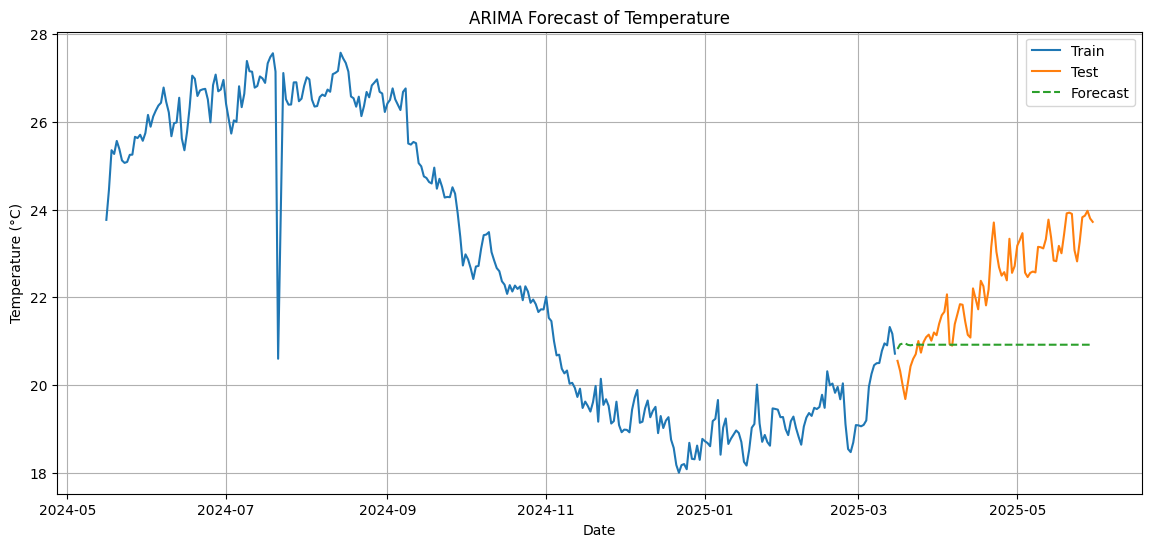

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Build and fit ARIMA model (basic config)
model = ARIMA(train, order=(5, 1, 0))  # (p,d,q) – can be tuned
model_fit = model.fit()

# Forecast into test set range
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['temperature_celsius'], label='Train')
plt.plot(test.index, test['temperature_celsius'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('ARIMA Forecast of Temperature')
plt.legend()
plt.grid(True)
plt.show()


Evaluate - Accuracy Metrics

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1.46
RMSE: 1.74


Feature Engineering:
Use the last_updated datetime feature to extract:

Day of week

Month

Is weekend or holiday flags
These can help the model capture seasonal or weekly trends.

Handling Missing Data:
If there are missing timestamps or values, apply interpolation or imputation.

In [17]:
# Convert 'last_updated' to datetime if not already
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Extract day of week (Monday=0, Sunday=6)
df['day_of_week'] = df['last_updated'].dt.dayofweek

# Extract month (1-12)
df['month'] = df['last_updated'].dt.month

# Weekend flag (1 if Saturday or Sunday, else 0)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# (Optional) Holiday flag: if you have a list of holidays, create a flag
# For example, if you have a list of holiday dates:
import holidays

# Assuming country is US; change as per your data location
us_holidays = holidays.UnitedStates()

df['is_holiday'] = df['last_updated'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Display first few rows to verify
df[['last_updated', 'day_of_week', 'month', 'is_weekend', 'is_holiday']].head()


,last_updated,day_of_week,month,is_weekend,is_holiday
186,2024-05-16 01:45:00,3,5,0,0
110,2024-05-16 02:45:00,3,5,0,0
40,2024-05-16 02:45:00,3,5,0,0
52,2024-05-16 02:45:00,3,5,0,0
68,2024-05-16 02:45:00,3,5,0,0


Handling Missing Data and Feature Engineering
1. Check for missing values:
We first identify missing values in each column to understand the extent of missing data in the dataset.
2. Visualize missing data:
A heatmap is used to visually inspect where the missing values occur, helping us spot patterns or blocks of missing data.
3. Create a complete datetime index:
We generate a full continuous date-time range (e.g., hourly) from the earliest to the latest timestamp in the data. This helps to capture any missing timestamps in the series.
4. Remove duplicate timestamps:
If multiple records exist for the same timestamp, only the first is kept to ensure each timestamp is unique.
5. Reindex the dataframe:
The dataframe is reindexed to the full continuous datetime index, introducing missing rows for timestamps not present in the original data.
6. Interpolate missing numeric values:
Numeric columns with missing values are filled using linear interpolation, estimating missing data points based on neighboring known values.
7. Fill missing categorical/non-numeric columns:
For non-numeric features, such as categorical or datetime-derived flags, missing values are filled appropriately (e.g., forward fill).
8. Extract new time-based features:
Day of week: Numeric day of the week (0 = Monday, … 6 = Sunday) is extracted to capture weekly seasonality.
Month: Month of the year is extracted to capture monthly or seasonal patterns.
Weekend flag: A binary flag to indicate if the day is a weekend (Saturday or Sunday).
Holiday flag: A binary flag to indicate if the date is a recognized holiday (based on a predefined holiday calendar).
9. Verify no missing values remain in numeric columns:
After interpolation, a check ensures all numeric features have no missing values, making the dataset ready for modeling.

Missing values per column:
 country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone   

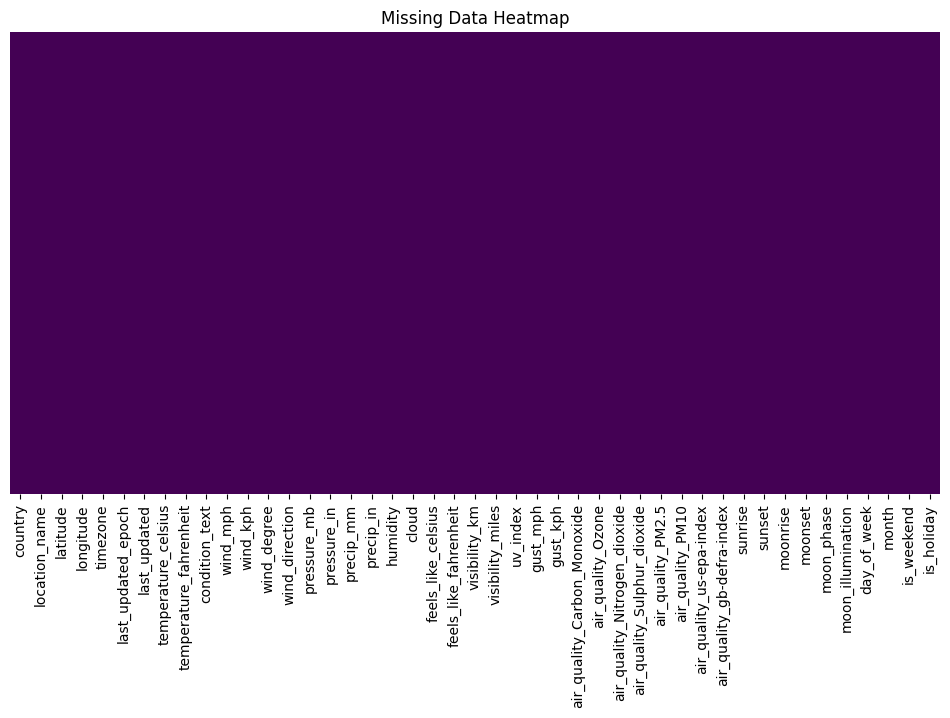

C:\Users\SARI SHREYA\AppData\Local\Temp\ipykernel_22792\4165324130.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(start=df['last_updated'].min(), end=df['last_updated'].max(), freq='H')  # Use 'D' for daily



Missing values after interpolation:
 latitude                        0
longitude                       0
last_updated_epoch              0
temperature_celsius             0
temperature_fahrenheit          0
wind_mph                        0
wind_kph                        0
wind_degree                     0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Nitrogen_dioxide    0
air_quality_Sulphur_dioxide     0
air_quality_PM2.5               0
air_quality_PM10                0
air_quality_us-epa-index        0
air_qualit

In [21]:
# Check for missing values in the dataset
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Optionally, visualize missing data pattern
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Handling missing timestamps:
# 1. Create a complete datetime index from min to max date by desired frequency (e.g., hourly or daily)

full_date_range = pd.date_range(start=df['last_updated'].min(), end=df['last_updated'].max(), freq='H')  # Use 'D' for daily

# Keep only the first record per timestamp
df = df.sort_values('last_updated')
df = df.drop_duplicates(subset=['last_updated'], keep='first')

# 2. Reindex the dataframe to this full date range
df = df.set_index('last_updated').reindex(full_date_range).rename_axis('last_updated').reset_index()

# 3. Interpolate missing numeric values (linear interpolation)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# 4. For non-numeric columns, fill missing values if needed (e.g., forward fill)
df['day_of_week'] = df['last_updated'].dt.dayofweek
df['month'] = df['last_updated'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_holiday'] = df['last_updated'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Verify no missing values remain in numeric features
print("\nMissing values after interpolation:\n", df[numeric_cols].isnull().sum())


MODEL2: LSTM


c:\Users\SARI SHREYA\OneDrive\Desktop\projects\ml_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0375 - val_loss: 0.0280
Epoch 2/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - loss: 0.0306 - val_loss: 0.0280
Epoch 3/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - loss: 0.0309 - val_loss: 0.0281
Epoch 4/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - loss: 0.0311 - val_loss: 0.0282
Epoch 5/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.0307 - val_loss: 0.0280
Epoch 6/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 0.0307 - val_loss: 0.0282
Epoch 7/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0308 - val_loss: 0.0280
Epoch 8/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 0.0305 - val_loss: 0.0280
Epoch 9/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0304 - val_loss: 0.0281
Epoch 10/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0302 - val_loss: 0.0280
Epoch 11/20
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - loss: 0.0306 - val_loss: 0.0284
Epoch 12

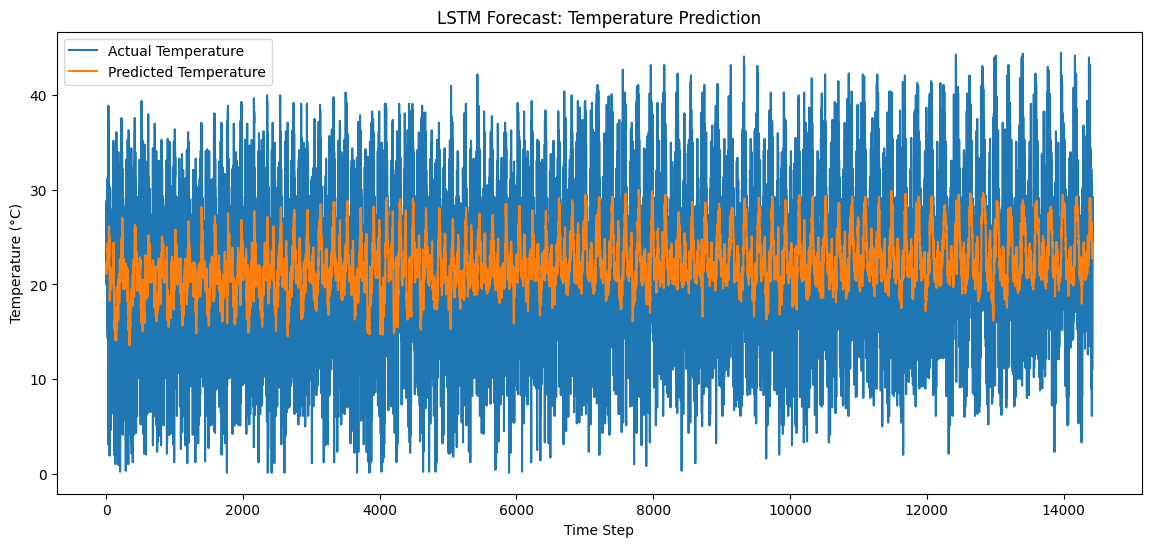

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Prepare data

# Assume df is loaded and 'last_updated' is datetime, sorted by time
df = df.sort_values('last_updated')

# Use temperature column
data = df['temperature_celsius'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM (e.g., use past 30 time steps to predict next)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split into train and test sets (e.g., 80% train)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 2. Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 3. Predict and inverse transform to original scale
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.title('LSTM Forecast: Temperature Prediction')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


Evaluate - Accuracy Metrics

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.3f} °C")
print(f"RMSE: {rmse:.3f} °C")
print(f"MAPE: {mape:.2f} %")


MAE: 6.026 °C
RMSE: 7.540 °C
MAPE: 59.92 %


MODEL3: RandomForest


Random Forest Regressor (with Time Features)

We will use the Random Forest Regressor to model the target variable using time-based and weather-related features. This allows the model to learn patterns based on temporal cycles and meteorological conditions.


Feature Selection and Splitting

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define your features
features = ['day_of_week', 'month', 'is_weekend', 
            'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'air_quality_PM2.5']

# Define your target variable (example: 'precip_mm')
target = 'precip_mm'

# Drop rows where target is missing
df_model = df.dropna(subset=[target])

# Split features and target
X = df_model[features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train the Random Forest Model

In [23]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Evaluate the Model

In [24]:
# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Random Forest Regressor Evaluation:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2 Score: {r2:.2f}")


Random Forest Regressor Evaluation:
RMSE: 0.37
MAE: 0.15
R2 Score: 0.44


Feature Importance

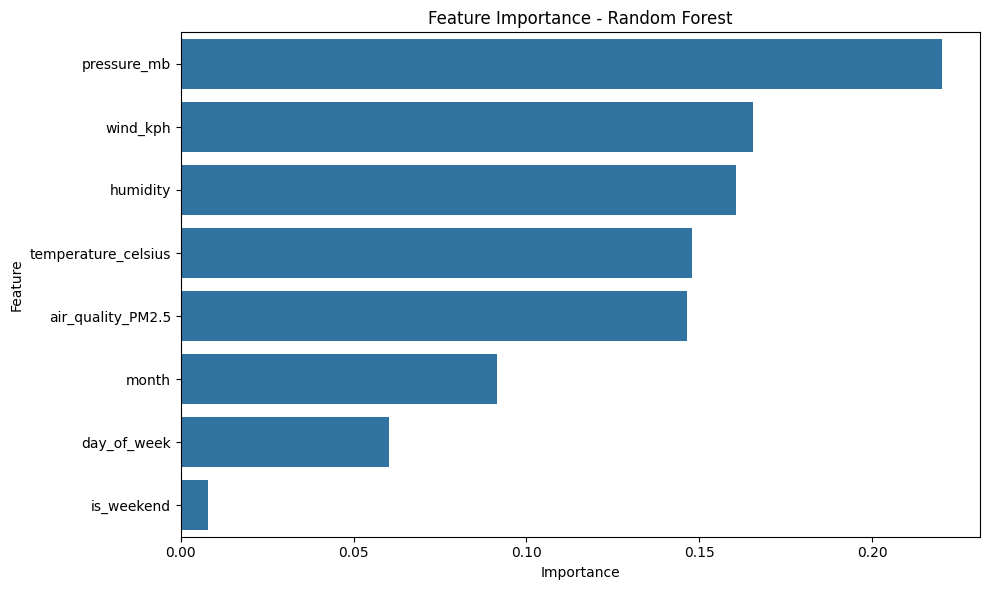

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()



Visualize Random Forest Predictions vs Actual

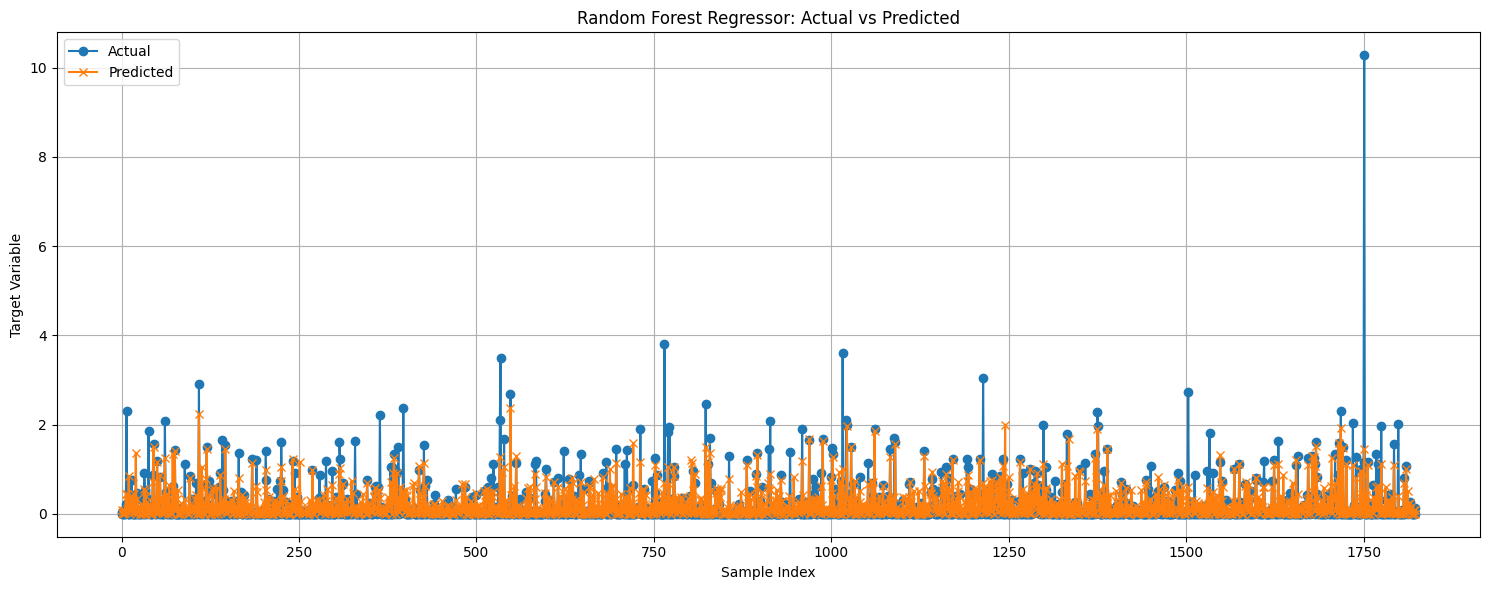

In [26]:
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Random Forest Regressor: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target Variable')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


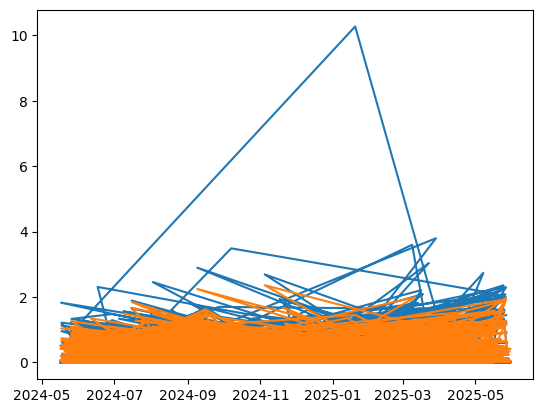

In [27]:
plt.plot(df.loc[X_test.index, 'last_updated'], y_test, label='Actual')
plt.plot(df.loc[X_test.index, 'last_updated'], y_pred, label='Predicted')


Evaluation metrics: Accuracy

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"arima_Mean Absolute Error (MAE): {mae:.3f}")
print(f"arima_Mean Squared Error (MSE): {mse:.3f}")
print(f"arima_Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"arima_R-squared (R²): {r2:.3f}")


Mean Absolute Error (MAE): 0.154
Mean Squared Error (MSE): 0.138
Root Mean Squared Error (RMSE): 0.372
R-squared (R²): 0.441
